In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import astropy
import scipy
from scipy import optimize
import pyCloudy as pc
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from scipy.interpolate import interp1d
from pyCloudy.utils.astro import conv_arc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib
#import glob
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)
from tqdm import tqdm
import timeit


pgf_with_latex = {
    "pgf.texsystem": "xelatex",         # use Xelatex which is TTF font aware
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",             # use serif rather than sans-serif
    "font.serif": "Ubuntu",             # use 'Ubuntu' as the standard font
    "font.sans-serif": [],
    "font.monospace": "Ubuntu Mono",    # use Ubuntu mono if we have mono
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "pgf.rcfonts": False,               # Use pgf.preamble, ignore standard Matplotlib RC
    "text.latex.unicode": True,
    "pgf.preamble": [
        r'\usepackage{fontspec}',
        r'\setmainfont{Ubuntu}',
        r'\setmonofont{Ubuntu Mono}',
        r'\usepackage{unicode-math}'
        r'\setmathfont{Ubuntu}',
        r'\usepackage{cmbright}',
        r'\usepackage{newtxtext,newtxmath}',
        r'\usepackage{wasysym}'
    ]
}

matplotlib.rcParams.update(pgf_with_latex)

dist = 1.65
home_dir = os.environ['HOME'] + '/'
pc.config.cloudy_exe = home_dir + 'c17.02/source/cloudy.exe'
arcsec = lambda cm: conv_arc(dist=dist, dist_proj=cm)

def make_model_met_dens(dir_, model_name, dens, met):
    
    full_model_name = '{0}_{1}_{2}'.format(model_name, dens, met)
    Teff = 30200. #K
    lumi = 69000.
    r_min = 6.05e16 #cm значение 6e11 изначально
    dist = 1.65
    options = ('no molecules', 'COSMIC RAY BACKGROUND',)
    emis_tab = ['H  1  4861.33A', #h beta
            'H  1  6562.81A', #h alpha
            'N  2  6583.45A', #
            'S  2  6716.44A', #
            'S  2  6730.82A'] #
    c_input = pc.CloudyInput('{0}{1}'.format(dir_, full_model_name))
    c_input.set_BB(Teff = Teff, lumi_unit = 'luminosity linear solar', lumi_value = lumi)
    c_input.set_cste_density(dens)
    c_input.set_other('abundances "solar_GASS10.abn" no grains')
    c_input.set_other('metals ' + met)
    c_input.set_radius(r_in=np.log10(r_min))
    c_input.set_other(options)
    c_input.set_iterate() 
    c_input.set_sphere() 
    c_input.set_emis_tab(emis_tab)
    c_input.set_distance(dist=dist, unit='kpc', linear=True)
    c_input.print_input(to_file = True, verbose = False)


def load_model_metallicity(min_dens, max_dens, count_dens, min_met, max_met, count_met, flag):

    dir_ = '/home/mdemyanenko/CLOUDY/'
    pc.print_make_file(dir_ = dir_)
    pc.log_.level = 2
    model_name = 'model_metallicity'
    tab_dens = np.linspace(min_dens, max_dens, count_dens) 
    tab_met = []


    for el in np.linspace(min_met, max_met, count_met):
        tab_met.append(str(el))

    if flag == False:
        
        Mss =[] # матрица с output моделями 
        for dens in tab_dens:
            for met in tab_met:
                n_proc = 32
                Mss.extend(pc.load_models('{0}{1}_{2}_{3}'.format(dir_, model_name, dens, met), 
                                  verbose = True, read_grains = False)) #поменять на pc.CloudyModel()
    elif flag == True:
        
        Mss =[]
        for dens in tab_dens:
            for met in tab_met:
                make_model_met_dens(dir_, model_name, dens, met)
                n_proc = 32
                pc.run_cloudy(dir_ = dir_, n_proc = n_proc, model_name = model_name, use_make = True)
                Mss.extend(pc.load_models('{0}{1}_{2}_{3}'.format(dir_, model_name, dens, met), 
                                  verbose = True, read_grains = False)) #поменять на pc.CloudyModel()
                
    return Mss


def flux_on_z(M_sphere, line):
    
    a = ((M_sphere.get_emis(line) * M_sphere.cub_coord.delta_x).sum(0))
    b = a / (4 * np.pi)
    
    return b * (np.pi/(180*3600))**2


def r_observe(filename, ra0, dec0): #arcsec

    hdulist = fits.open(filename) 
    f_o = hdulist[0].data
    wcs_hst = WCS(hdulist[0].header) 
    X, Y = np.meshgrid(np.arange(0, f_o.shape[0]), np.arange(0, f_o.shape[1]))
    ra, dec = wcs_hst.wcs_pix2world(X, Y, 0)
    r = np.sqrt(((ra-ra0)*np.cos(dec*np.pi/180))**2 + (dec-dec0)**2)
    
    return r*3600


def flux_observe(filename):
    
    hdulist = fits.open(filename)
    f_o = hdulist[0].data
    
    return f_o


def flux_err_observe(filename_err):
    
    hdulist_err = fits.open(filename_err)
    sigma = hdulist_err[0].data
    
    return sigma


def f_cloudy_interp(line, output_sphere_model, filename, ra0, dec0):
    
    arcsec = lambda cm: conv_arc(dist=dist, dist_proj=cm)
    x_arc = abs(arcsec(output_sphere_model.cub_coord.x_vec))
    f = flux_on_z(output_sphere_model, line)[:,31]
    f_1 = interp1d(x_arc, f, kind = 'linear', bounds_error = False, fill_value = 0)
    ff = f_1(r_observe(filename, ra0, dec0))
    
    return ff


def snr(filename, filename_err, ra0, dec0):
    flux_obs = flux_observe(filename)
    flux_err = flux_err_observe(filename_err)
    radius = r_observe(filename, ra0, dec0)
    sn = flux_obs/flux_err
    mask = (sn > 4)&(sn < 50)&(flux_obs > 8e-16)&(flux_err > 8e-16)#&(radius > 20)
    sn[~mask] = 0
    
    #for i in range(0, 64):
    #    for j in range(0, 64):
    #        if (mask[i][j] == True)&(r_observe(filename, ra0, dec0)[i][j] > 20):
    #            sn[i][j] = sn[i][j]
    #        else:
    #            sn[i][j] = 0
    
    return sn


def mask__snr_for_array(dimenshions, array, min_snr, max_snr, filename, filename_err, ra0, dec0):
    flux_obs = flux_observe(filename)
    flux_err = flux_err_observe(filename_err)
    radius = r_observe(filename, ra0, dec0)
    sn = flux_obs / flux_err
    mask = (sn > min_snr) & \
           (sn < max_snr) & \
           (flux_obs > 8e-16) & \
           (flux_obs < 1e-12) & \
           (flux_err > 8e-16) & \
           (flux_err < 1e-12) & \
           (radius > 20)
    
    array[~mask] = 0
    
    #mask_2 = r_observe(filename, ra0, dec0)
    #for i in range(0, dimenshions):
    #    for j in range(0, dimenshions):
    #        if (mask[i][j] == True)&(mask_2[i][j] > 20):
    #            array[i][j] = array[i][j]
    #        else:
    #            array[i][j] = 0
                
    return array


def hihi_line_mask(output_sphere_model, line, filename, filename_err, ra0, dec0):
    
    hdulist = fits.open(filename) 
    f_o = hdulist[0].data
    flux_err = flux_err_observe(filename_err)
    wcs_hst = WCS(hdulist[0].header) 
    X, Y = np.meshgrid(np.arange(0, f_o.shape[0]), np.arange(0, f_o.shape[1])) # так как у fits файлов x,y=y,x
    ra, dec = wcs_hst.wcs_pix2world(X, Y, 0)
    r = np.sqrt(((ra-ra0)*np.cos(dec*np.pi/180))**2 + (dec-dec0)**2)
    arcsec = lambda cm: conv_arc(dist=dist, dist_proj=cm)
    x_arc = abs(arcsec(output_sphere_model.cub_coord.x_vec))
    f = flux_on_z(output_sphere_model, line)[31, :]
    r_new = 3600 * r
    f_1 = interp1d(x_arc, f, kind = 'linear', bounds_error = False, fill_value = 0)
    ff = f_1(r_new)
    hii = (ff - f_o)**2 / (((flux_err)**2)*(r_new))
    result = mask__snr_for_array(64, hii, 4, 50, filename, filename_err, ra0, dec0)
    
    return result


def hihi_sum_mask(output_sphere_model):
    
    a_1 = hihi_line_mask(output_sphere_model, 'S__2_671644A',
         '/home/mdemyanenko/CLOUDY/S235_mangal/S235_6717net0_ergs_dereddened.fits',
         '/home/mdemyanenko/CLOUDY/S235_mangal/S235_err_6717_ergs_dereddened.fits',
         85.24766667, +35.84625000)
    a_2 = hihi_line_mask(output_sphere_model, 'S__2_673082A',
        '/home/mdemyanenko/CLOUDY/S235_mangal/S235_6731net0_ergs_dereddened.fits',
        '/home/mdemyanenko/CLOUDY/S235_mangal/S235_err_6731_ergs_dereddened.fits',
        85.24766667, +35.84625000)
    a_3 = hihi_line_mask(output_sphere_model, 'H__1_486133A', 
       '/home/mdemyanenko/CLOUDY/S235_mangal/S235_Hb_23toHa_ergs_dereddened.fits', 
       '/home/mdemyanenko/CLOUDY/S235_mangal/S235_err_Hb_23_ergs_dereddened.fits',
        85.24766667, +35.84625000)
    a_4 = hihi_line_mask(output_sphere_model, 'H__1_656281A', 
       '/home/mdemyanenko/CLOUDY/S235_mangal/S235_Hanet0_ergs_dereddened.fits', 
       '/home/mdemyanenko/CLOUDY/S235_mangal/S235_err_Ha_ergs_dereddened.fits',
        85.24766667, +35.84625000)
    a_5 = hihi_line_mask(output_sphere_model, 'N__2_658345A', 
       '/home/mdemyanenko/CLOUDY/S235_mangal/S235scan_6583_1x1_ergs_dereddened.fits', 
       '/home/mdemyanenko/CLOUDY/S235_mangal/S235_err_NII_1x1_ergs_dereddened.fits',
        85.24766667, +35.84625000)

    hihi_sum = a_1+a_2+a_3+a_4+a_5

    return hihi_sum


def sum_hihi_sum_mask(output_sphere_model):
    
    chi_sum = np.nansum(hihi_sum_mask(output_sphere_model))
    
    return chi_sum


def str_tab_to_float(tab):
    
    tab_new = []
    for el in tab:
        tab_new.append(float(el))
        
    return tab_new


def reshape_models_matrix(tab_one, tab_two):
    
    Mss_for_pcolor = np.reshape(Mss, (len(tab_one), len(tab_two)))
    
    return Mss_for_pcolor


def chi_for_all_models(Mss, cube_size = 64):
    
    chi = [sum_hihi_sum_mask(pc.C3D(M, dims=cube_size, center=True, n_dim=1)) for M in Mss]
    
    return chi


def pcolor_hi_from_two_param(tab_one, tab_two, x, y, cube_size = 64):
    
    chi = [sum_hihi_sum_mask(pc.C3D(M, dims=cube_size, center=True, n_dim=1)) for M in Mss]
    plt.figure(figsize=(10,10))
    plt.pcolor(tab_one, tab_two, np.reshape(chi, (len(tab_one), len(tab_two))))
    plt.xlabel(r'$'+x+'$', size = 25)
    plt.ylabel(r'$'+y+'$', size = 25)
    cb = plt.colorbar()
    cb.set_label(r'$\chi^{2}$', size = 25)
    plt.title('Sh2-235', size = 25);

    
def min_of_array(list_chi, tab_one, tab_two):
    
    array = np.reshape(list_chi, (len(tab_one), len(tab_two)))
    index = np.argmin(array)
    tab_onee, tab_twoo = np.meshgrid(tab_mett, tab_dens)
    min_point = [tab_onee[index], tab_twoo[index], array[index]]
    
    return min_point


def minimization_chi_from_n_z(min_dens, max_dens, count_dens, min_met, max_met, count_met, depth): # dummy 
    
    for i in range(depth):
        
        Mss = load_model_metallicity(min_dens, max_dens, count_dens, min_met, max_met, count_met, True)
        chi = chi_for_all_models(Mss)
        tab_one = np.linspace(min_dens, max_dens, count_dens) 
        
        tab_two = []
        
        for el in np.linspace(min_met, max_met, count_met):
            tab_two.append(el)
            
        point = min_of_array(chi, tab_one, tab_two)
        step_dens = (max_dens - min_dens)/count_dens
        step_met = (max_met - min_met)/count_met
        min_dens = point[0] - step_dens
        max_dens = point[0] + step_dens
        min_met = point[1] - step_met
        max_met = point[1] + step_met    
        #minimization_chi(min_dens, max_dens, count_dens, min_met, max_met, count_met)
        
    return point
    
    
def n_0_for_input(n, alpha):#, gamma = 0.01): # n --> n_0 (при заданной gamma , где gamma = r_in/r_out) 
    
    angular_size = 720 #arcsec diametre --> то есть считаю из видимого размера 
    size = (dist * 1000 * 206265 * 149600000 * 1000 * 100 * angular_size) / (2 * 206265) #r_out in cm
    radius_stellar = 100 * np.sqrt(69000*3.827e26/(4 * np.pi * 5.670367e-8*((30200)**4)))
    r_itternal = 100 * radius_stellar
    mass = (4/3)* np.pi * n * (size**3 - r_itternal**3)
    n_0 = mass * (r_itternal**alpha)*(alpha + 3)/(4*np.pi*(size**(alpha + 3) - r_itternal**(alpha + 3)))
    #n_0 = n * (1 - gamma**3)*(gamma**alpha)*(alpha + 3) / (3 * (1 - gamma**(alpha + 3))) - так делать нельзя, так как gamma зависит от n при одинаковой массе
    
    return np.log10(n_0)


def make_model_dens_alpha(dir_, model_name, dens, alpha):
    
    full_model_name = '{0}_{1}{2}'.format(model_name, dens, alpha)
    Teff = 30200. #K
    lumi = 69000.
    r_min = 100 * 100 * np.sqrt(69000*3.827e26/(4 * np.pi * 5.670367e-8*((30200)**4)))#6.05e16 #cm значение 6e11 изначально
    dist = 1.65
    options = ('no molecules', 'COSMIC RAY BACKGROUND')
    emis_tab = ['H  1  4861.33A', #h beta
            'H  1  6562.81A', #h alpha
            'N  2  6583.45A', #
            'S  2  6716.44A', #
            'S  2  6730.82A'] #
    c_input = pc.CloudyInput('{0}{1}'.format(dir_, full_model_name))
    c_input.set_BB(Teff = Teff, lumi_unit = 'luminosity linear solar', lumi_value = lumi)
    n_0 = n_0_for_input(dens, alpha)
    c_input.set_other('hden ' + str(n_0) + ', power =' + str(alpha))
    c_input.set_other('abundances "solar_GASS10.abn" no grains')
    c_input.set_other('metals 0.57')
    c_input.set_radius(r_in = np.log10(r_min))
    c_input.set_other(options)
    c_input.set_iterate() 
    c_input.set_sphere() 
    c_input.set_emis_tab(emis_tab)
    c_input.set_distance(dist = dist, unit = 'kpc', linear = True)
    c_input.print_input(to_file = True, verbose = False)
    
    
def load_model_dens_alpha(min_dens, max_dens, count_dens, min_alpha, max_alpha, count_alpha, flag):

    dir_ = '/home/mdemyanenko/CLOUDY/'
    pc.print_make_file(dir_ = dir_)
    pc.log_.level = 2
    model_name = 'model_dens_alpha'
    tab_dens = np.linspace(min_dens, max_dens, count_dens) 
    
    tab_alpha = np.linspace(min_alpha, max_alpha, count_alpha)

    if flag == False:
        
        Mss = [] # матрица с output моделями 
        
        for dens in tab_dens:
            for alpha in tab_alpha:
                n_proc = 32
                Mss.extend(pc.load_models('{0}{1}_{2}_{3}'.format(dir_, model_name, dens, alpha), 
                                  verbose = True, read_grains = False))
    elif flag == True:
        
        Mss = []
        
        for dens in tab_dens:
            for alpha in tab_alpha:
                make_model_dens_alpha(dir_, model_name, dens, alpha)
                n_proc = 32
                pc.run_cloudy(dir_ = dir_, n_proc = n_proc, model_name = model_name, use_make = True)
                Mss.extend(pc.load_models('{0}{1}_{2}_{3}'.format(dir_, model_name, dens, alpha), 
                                  verbose = True, read_grains = False))
                
    return Mss


def minimization_chi_from_n_a(min_dens, max_dens, count_dens, min_alpha, max_alpha, count_alpha, depth): # dummy 
    
    for i in range(depth):
        
        Mss = load_model_dens_alpha(min_dens, max_dens, count_dens, min_alpha, max_alpha, count_alpha, True)
        chi = chi_for_all_models(Mss)
        tab_one = np.linspace(min_dens, max_dens, count_dens) 
        
        tab_two = np.linspace(min_alpha, max_alpha, count_alpha)
            
        point = min_of_array(chi, tab_one, tab_two)
        step_dens = (max_dens - min_dens)/count_dens
        step_alpha = (max_alpha - min_alpha)/count_alpha
        min_dens = point[0] - step_dens
        max_dens = point[0] + step_dens
        min_alpha = point[1] - step_alpha
        max_alpha = point[1] + step_alpha    
        #minimization_chi(min_dens, max_dens, count_dens, min_met, max_met, count_met)
        
    return point

def ratio_flux(M_sphere, line1, line2):
    
    h = flux_on_z(M_sphere, line1)/flux_on_z(M_sphere, line2)
    
    return h


def beauty_for_line(line): # для того, чтобы правильно задавать эмиссионную линию в названии графика
    sss = line[:-3]
    d = sss.split("__")
    g = d[0] + ''.join(d[1].split("_"))
    if int(g[1]) == 1:
        g = r'\textbf{[' + g[:1] + 'I' + '](' + g[2:] + ')}'
        return g
    elif int(g[1]) == 2:
        g = r'\textbf{[' + g[:1] + 'II' + '](' + g[2:] + ')}'
        return g
    
    
def plot_dlow_examples(M_sphere):
    fig = plt.figure(figsize=(33, 33))
    ax_1 = fig.add_subplot(6,1,1)
    ax_2 = fig.add_subplot(6,1,2)
    ax_3 = fig.add_subplot(6,1,3)
    ax_4 = fig.add_subplot(6,1,4)
    ax_5 = fig.add_subplot(6,1,5)
    ax_6 = fig.add_subplot(6,1,6)
    ax_1.set_xlabel(r'\textbf{arcsec}', size=20)
    ax_1.set_ylabel(r'\textbf{arcsec}', size=20)
    ax_2.set_xlabel(r'\textbf{arcsec}', size=20)
    ax_2.set_ylabel(r'\textbf{arcsec}', size=20)
    ax_3.set_xlabel(r'\textbf{arcsec}', size=20)
    ax_3.set_ylabel(r'\textbf{arcsec}', size=20)
    ax_4.set_xlabel(r'\textbf{arcsec}', size=20)
    ax_4.set_ylabel(r'\textbf{arcsec}', size=20)
    ax_5.set_xlabel(r'\textbf{arcsec}', size=20)
    ax_5.set_ylabel(r'\textbf{arcsec}', size=20)
    ax_6.set_xlabel(r'\textbf{arcsec}', size=20)
    ax_6.set_ylabel(r'\textbf{arcsec}', size=20)
    fig.suptitle(r'Model 2 for $\alpha = -1$'+r'\\ \\ Intensity $[erg s^{-1} cm^{-2} arcsec^{-2}]$', y = 0.91, ha = 'center', va = 'center', fontsize = 25)
    ax_1.set_title(r'\textbf{SII ratio}', size=20)
    ax_2.set_title(beauty_for_line('S__2_671644A'), size=20)
    ax_3.set_title(beauty_for_line('S__2_673082A'), size=20)
    ax_4.set_title(r'\textbf{$H_{\beta}$(4861)}', size=20)
    ax_5.set_title(r'\textbf{$H_{\alpha}$(6563)}', size=20)
    ax_6.set_title(beauty_for_line('N__2_658345A'), size=20)
    arcsec = lambda cm: conv_arc(dist=dist, dist_proj=cm)
    x_arc = arcsec(M_sphere.cub_coord.x_vec)
    y_arc = arcsec(M_sphere.cub_coord.y_vec)
    x_max = np.max(arcsec(M_sphere.cub_coord.z_vec))
    im_1 = ax_1.imshow(ratio_flux(M_sphere, 'S__2_671644A', 'S__2_673082A'), 
               extent=(np.min(arcsec(M_sphere.cub_coord.x_vec)),
                       np.max(arcsec(M_sphere.cub_coord.x_vec)),
                       np.min(arcsec(M_sphere.cub_coord.y_vec)),
                       np.max(arcsec(M_sphere.cub_coord.y_vec))));
    divider_1 = make_axes_locatable(ax_1)
    cax_1 = divider_1.append_axes('right', size='5%', pad=0.07)
    fig.colorbar(im_1, cax=cax_1, orientation='vertical')
    im_2 = ax_2.imshow(flux_on_z(M_sphere, 'S__2_671644A'), 
               extent=(np.min(arcsec(M_sphere.cub_coord.x_vec)),
                       np.max(arcsec(M_sphere.cub_coord.x_vec)),
                       np.min(arcsec(M_sphere.cub_coord.y_vec)),
                       np.max(arcsec(M_sphere.cub_coord.y_vec))));
    divider_2 = make_axes_locatable(ax_2)
    cax_2 = divider_2.append_axes('right', size='5%', pad=0.07)
    fig.colorbar(im_2, cax=cax_2, orientation='vertical')
    im_3 = ax_3.imshow(flux_on_z(M_sphere, 'S__2_673082A'), 
               extent=(np.min(arcsec(M_sphere.cub_coord.x_vec)),
                       np.max(arcsec(M_sphere.cub_coord.x_vec)),
                       np.min(arcsec(M_sphere.cub_coord.y_vec)),
                       np.max(arcsec(M_sphere.cub_coord.y_vec))));
    divider_3 = make_axes_locatable(ax_3)
    cax_3 = divider_3.append_axes('right', size='5%', pad=0.07)
    fig.colorbar(im_3, cax=cax_3, orientation='vertical')
    im_4 = ax_4.imshow(flux_on_z(M_sphere, 'H__1_486133A'), 
               extent=(np.min(arcsec(M_sphere.cub_coord.x_vec)),
                       np.max(arcsec(M_sphere.cub_coord.x_vec)),
                       np.min(arcsec(M_sphere.cub_coord.y_vec)),
                       np.max(arcsec(M_sphere.cub_coord.y_vec))));
    divider_4 = make_axes_locatable(ax_4)
    cax_4 = divider_4.append_axes('right', size='5%', pad=0.07)
    fig.colorbar(im_4, cax=cax_4, orientation='vertical')
    im_5 = ax_5.imshow(flux_on_z(M_sphere, 'H__1_656281A'), 
               extent=(np.min(arcsec(M_sphere.cub_coord.x_vec)),
                       np.max(arcsec(M_sphere.cub_coord.x_vec)),
                       np.min(arcsec(M_sphere.cub_coord.y_vec)),
                       np.max(arcsec(M_sphere.cub_coord.y_vec))));
    divider_5 = make_axes_locatable(ax_5)
    cax_5 = divider_5.append_axes('right', size='5%', pad=0.07)
    fig.colorbar(im_5, cax=cax_5, orientation='vertical')
    im_6 = ax_6.imshow(flux_on_z(M_sphere, 'N__2_658345A'), 
               extent=(np.min(arcsec(M_sphere.cub_coord.x_vec)),
                       np.max(arcsec(M_sphere.cub_coord.x_vec)),
                       np.min(arcsec(M_sphere.cub_coord.y_vec)),
                       np.max(arcsec(M_sphere.cub_coord.y_vec))));
    divider_6 = make_axes_locatable(ax_6)
    cax_6 = divider_6.append_axes('right', size='5%', pad=0.07)
    fig.colorbar(im_6, cax=cax_6, orientation='vertical')
    fig.subplots_adjust(hspace=0.33)

    
def get_observe_data(M_sphere, line, ra0, dec0, filename, filename_err): 

            fig = plt.figure(figsize = (14, 14))
            ax_1 = fig.add_subplot(1,1,1)
            fig.suptitle(r'\textbf{Intensity on  }' + beauty_for_line(line), fontsize = 25)
            ax_1.set_xlabel(r"\textbf{arcsec}", size = 20)
            ax_1.set_ylabel(r"\textbf{Intensity on line $[ergs^{-1}cm^{-2}arcsec^{-2}]$}", size= 20)
            hdulist = fits.open(filename)
            obs_data = hdulist[0].data 
            wcs_hst = WCS(hdulist[0].header)  
            X, Y = np.meshgrid(np.arange(0, obs_data.shape[0]), np.arange(0, obs_data.shape[1]))
            ra, dec = wcs_hst.wcs_pix2world(X, Y, 0)
            r = np.sqrt(((ra-ra0)*np.cos(dec*np.pi/180))**2 + (dec-dec0)**2)
            x_arc = arcsec(M_sphere.cub_coord.x_vec)
            y_arc = arcsec(M_sphere.cub_coord.y_vec)
            x_max = np.max(arcsec(M_sphere.cub_coord.z_vec))
            ax_1.set_title(r'\textbf{Observed and Cloudy profiles}', size = 20)
            ax_1.set_xlim([0, 1.05 * np.max(r*3600)])
            ax_1.plot(x_arc, flux_on_z(M_sphere, line)[:, 31]) 
            ax_1.plot(r*3600, mask__snr_for_array(64, obs_data, 4, 50, filename, filename_err, 85.24766667, +35.84625000), '.')
            ax_1.set_ylim([0, 1e-13])#np.nanmax(mask__snr_for_array(64, obs_data, 4, 50, filename, filename_err, 85.24766667, +35.84625000))] )
            
            
def get_observe_data_ratio(M_sphere, ra0, dec0): 

            fig = plt.figure(figsize = (14, 14))
            ax_1 = fig.add_subplot(1,1,1)
            fig.suptitle(r'\textbf{SII ratio}' , fontsize = 25)
            ax_1.set_xlabel(r"\textbf{arcsec}", size = 20)
            ax_1.set_ylabel(r"\textbf{Intensity on line $[ergs^{-1}cm^{-2}arcsec^{-2}]$}", size= 20)
            hdulist_1 = fits.open('/home/mdemyanenko/CLOUDY/S235_mangal/S235_6717net0_ergs_dereddened.fits')
            obs_data_1 = hdulist_1[0].data 
            hdulist_2 = fits.open('/home/mdemyanenko/CLOUDY/S235_mangal/S235_6731net0_ergs_dereddened.fits')
            obs_data_2 = hdulist_2[0].data 
            wcs_hst = WCS(hdulist_1[0].header)  
            X, Y = np.meshgrid(np.arange(0, obs_data_1.shape[0]), np.arange(0, obs_data_1.shape[1]))
            ra, dec = wcs_hst.wcs_pix2world(X, Y, 0)
            r = np.sqrt(((ra-ra0)*np.cos(dec*np.pi/180))**2 + (dec-dec0)**2)
            x_arc = arcsec(M_sphere.cub_coord.x_vec)
            y_arc = arcsec(M_sphere.cub_coord.y_vec)
            x_max = np.max(arcsec(M_sphere.cub_coord.z_vec))
            ax_1.set_xlim([0, 1.05 * np.max(r*3600)])

            ax_1.plot(x_arc, ratio_flux(M_sphere, 'S__2_671644A', 'S__2_673082A')[:, 31]) 
#            ax_1.set_ylim([0, 1.05 * np.max(ratio_flux(M_sphere, 'S__2_671644A', 'S__2_673082A')[:, 31])] )
            ax_1.plot(r*3600, mask__snr_for_array(64, obs_data_1/obs_data_2, 4, 50,
                                                  '/home/mdemyanenko/CLOUDY/S235_mangal/S235_6717net0_ergs_dereddened.fits',
                                                  '/home/mdemyanenko/CLOUDY/S235_mangal/S235_err_6717_ergs_dereddened.fits',
                                                  ra0, dec0), '.')
            ax_1.set_ylim([0.1, 3]) #1.05 * np.nanmax(ratio_flux(M_sphere, 'S__2_671644A', 'S__2_673082A')[:, 31])])
            

/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:191: RuntimeWarning: invalid value encountered in greater
/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:191: RuntimeWarning: invalid value encountered in less


/usr/lib64/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib64/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib64/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib64/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


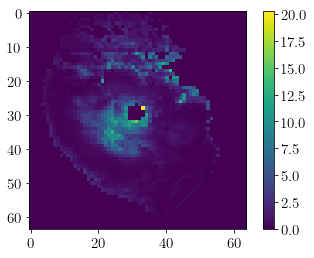

In [3]:
c_output = pc.CloudyModel('/home/mdemyanenko/CLOUDY/model_alpha_45[-0.76249999]')
cube_size = 64
M_sphere = pc.C3D(c_output, dims=cube_size, center=True, n_dim=1)
chi = hihi_sum_mask(M_sphere)
plt.imshow(chi)
plt.colorbar()

In [4]:
sum_hihi_sum_mask(M_sphere)

/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:191: RuntimeWarning: invalid value encountered in greater
/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:191: RuntimeWarning: invalid value encountered in less


3388.7116091166326

/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:191: RuntimeWarning: invalid value encountered in greater
/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:191: RuntimeWarning: invalid value encountered in less


/usr/lib64/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


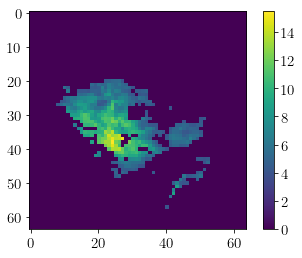

In [12]:
filename = '/home/mdemyanenko/CLOUDY/S235_mangal/S235_6717net0_ergs_dereddened.fits'
filename_err = '/home/mdemyanenko/CLOUDY/S235_mangal/S235_err_6717_ergs_dereddened.fits'
ra0 = 85.24766667
dec0 = +35.84625000
snrr = mask__snr_for_array(64, flux_observe(filename)/flux_err_observe(filename_err), 4, 50, filename, filename_err, ra0, dec0)
#snrr = snr(filename, filename_err, 85.2475, +35.84611111)
plt.imshow(snrr)
plt.colorbar()

/usr/lib64/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


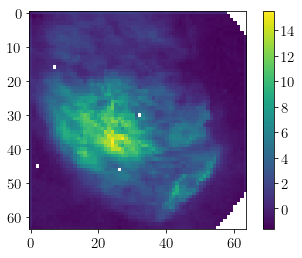

In [13]:
flux_obs = flux_observe(filename)
flux_err = flux_err_observe(filename_err)
sn = flux_obs/flux_err
plt.imshow(sn)
plt.colorbar()

In [14]:
#13.11.2020
def chi_from_model(alpha, dens = 45, cube_size = 64): #для варьирования градиента и средней плотности
    dir_ = '/home/mdemyanenko/CLOUDY/'
    pc.print_make_file(dir_ = dir_)
    pc.log_.level = 2
    model_name = 'model_alpha'
    make_model_dens_alpha(dir_, model_name, dens, alpha)
    n_proc = 32
    pc.run_cloudy(dir_ = dir_, n_proc = n_proc, model_name = model_name, use_make = True)
    full_model_name = '{0}_{1}{2}'.format(model_name, dens, alpha)
    model_object = pc.CloudyModel(full_model_name) # pc.load_models('{0}{1}_{2}{3}'.format(dir_, model_name, dens, alpha), verbose = True, read_grains = False)
    model_object.print_stats()
    M_sp = pc.C3D(model_object, dims=cube_size, center=True, n_dim=1)
    #plt.imshow(hihi_sum_mask(M_sp))
    #plt.colorbar()
    chi_mean = sum_hihi_sum_mask(M_sp)
    #hp = M_sphere.Hp_mass
    #h = M_sphere.H_mass
    return chi_mean

In [15]:
minimum = optimize.fmin(chi_from_model, -1, full_output = True)

warng CloudyInput: "None" parameter not printed
 Name of the model: model_alpha_45[-1.]
 R_in (cut) = 6.668e+13 (6.668e+13), R_out (cut) = 7.282e+18 (7.282e+18)
 H+ mass = 7.18e+01, H mass = 7.37e+01 N zones: 384
 <H+/H> = 0.99, <He++/He> = 0.00, <He+/He> = 0.42
 <O+++/O> = 0.00, <O++/O> = 0.18, <O+/O> = 0.81
 <N+++/N> = 0.00, <N++/N> = 0.29, <N+/N> = 0.70
 T(O+++) = 12650, T(O++) = 7550, T(O+) = 7507
 <ne> = 53,  <nH> = 54, T0 = 7514, t2=0.0014
 <log U> = -2.36
warng CloudyInput: "None" parameter not printed
 Name of the model: model_alpha_45[-1.05]
 R_in (cut) = 6.668e+13 (6.668e+13), R_out (cut) = 6.732e+18 (6.732e+18)
 H+ mass = 6.23e+01, H mass = 6.39e+01 N zones: 394
 <H+/H> = 0.99, <He++/He> = 0.00, <He+/He> = 0.42
 <O+++/O> = 0.00, <O++/O> = 0.20, <O+/O> = 0.79
 <N+++/N> = 0.00, <N++/N> = 0.31, <N+/N> = 0.68
 T(O+++) = 12826, T(O++) = 7638, T(O+) = 7556
 <ne> = 59,  <nH> = 59, T0 = 7571, t2=0.0017
 <log U> = -2.33
warng CloudyInput: "None" parameter not printed
 Name of the mod

warng CloudyInput: "None" parameter not printed
 Name of the model: model_alpha_45[-0.7609375]
 R_in (cut) = 6.668e+13 (6.668e+13), R_out (cut) = 8.566e+18 (8.566e+18)
 H+ mass = 9.90e+01, H mass = 1.02e+02 N zones: 376
 <H+/H> = 0.99, <He++/He> = 0.00, <He+/He> = 0.40
 <O+++/O> = 0.00, <O++/O> = 0.14, <O+/O> = 0.85
 <N+++/N> = 0.00, <N++/N> = 0.25, <N+/N> = 0.74
 T(O+++) = 10867, T(O++) = 7351, T(O+) = 7372
 <ne> = 46,  <nH> = 46, T0 = 7368, t2=0.0009
 <log U> = -2.42
warng CloudyInput: "None" parameter not printed
 Name of the model: model_alpha_45[-0.7640625]
 R_in (cut) = 6.668e+13 (6.668e+13), R_out (cut) = 8.557e+18 (8.557e+18)
 H+ mass = 9.88e+01, H mass = 1.01e+02 N zones: 376
 <H+/H> = 0.99, <He++/He> = 0.00, <He+/He> = 0.40
 <O+++/O> = 0.00, <O++/O> = 0.14, <O+/O> = 0.85
 <N+++/N> = 0.00, <N++/N> = 0.25, <N+/N> = 0.74
 T(O+++) = 10895, T(O++) = 7352, T(O+) = 7373
 <ne> = 46,  <nH> = 46, T0 = 7370, t2=0.0009
 <log U> = -2.42
warng CloudyInput: "None" parameter not printed
 Nam

warng CloudyInput: "None" parameter not printed
 Name of the model: model_alpha_45[-0.76247559]
 R_in (cut) = 6.668e+13 (6.668e+13), R_out (cut) = 8.561e+18 (8.561e+18)
 H+ mass = 9.89e+01, H mass = 1.01e+02 N zones: 376
 <H+/H> = 0.99, <He++/He> = 0.00, <He+/He> = 0.40
 <O+++/O> = 0.00, <O++/O> = 0.14, <O+/O> = 0.85
 <N+++/N> = 0.00, <N++/N> = 0.25, <N+/N> = 0.74
 T(O+++) = 10881, T(O++) = 7352, T(O+) = 7373
 <ne> = 46,  <nH> = 46, T0 = 7369, t2=0.0009
 <log U> = -2.42
warng CloudyInput: "None" parameter not printed
 Name of the model: model_alpha_45[-0.76252441]
 R_in (cut) = 6.668e+13 (6.668e+13), R_out (cut) = 8.561e+18 (8.561e+18)
 H+ mass = 9.89e+01, H mass = 1.01e+02 N zones: 376
 <H+/H> = 0.99, <He++/He> = 0.00, <He+/He> = 0.40
 <O+++/O> = 0.00, <O++/O> = 0.14, <O+/O> = 0.85
 <N+++/N> = 0.00, <N++/N> = 0.25, <N+/N> = 0.74
 T(O+++) = 10881, T(O++) = 7352, T(O+) = 7373
 <ne> = 46,  <nH> = 46, T0 = 7369, t2=0.0009
 <log U> = -2.42
warng CloudyInput: "None" parameter not printed
 N

warng CloudyInput: "None" parameter not printed
 Name of the model: model_alpha_45[-0.76249981]
 R_in (cut) = 6.668e+13 (6.668e+13), R_out (cut) = 8.562e+18 (8.562e+18)
 H+ mass = 9.89e+01, H mass = 1.01e+02 N zones: 376
 <H+/H> = 0.99, <He++/He> = 0.00, <He+/He> = 0.40
 <O+++/O> = 0.00, <O++/O> = 0.14, <O+/O> = 0.85
 <N+++/N> = 0.00, <N++/N> = 0.25, <N+/N> = 0.74
 T(O+++) = 10881, T(O++) = 7352, T(O+) = 7373
 <ne> = 46,  <nH> = 46, T0 = 7369, t2=0.0009
 <log U> = -2.42
warng CloudyInput: "None" parameter not printed
 Name of the model: model_alpha_45[-0.76250019]
 R_in (cut) = 6.668e+13 (6.668e+13), R_out (cut) = 8.561e+18 (8.561e+18)
 H+ mass = 9.89e+01, H mass = 1.01e+02 N zones: 376
 <H+/H> = 0.99, <He++/He> = 0.00, <He+/He> = 0.40
 <O+++/O> = 0.00, <O++/O> = 0.14, <O+/O> = 0.85
 <N+++/N> = 0.00, <N++/N> = 0.25, <N+/N> = 0.74
 T(O+++) = 10881, T(O++) = 7351, T(O+) = 7373
 <ne> = 46,  <nH> = 46, T0 = 7369, t2=0.0009
 <log U> = -2.42
warng CloudyInput: "None" parameter not printed
 N

/usr/lib64/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


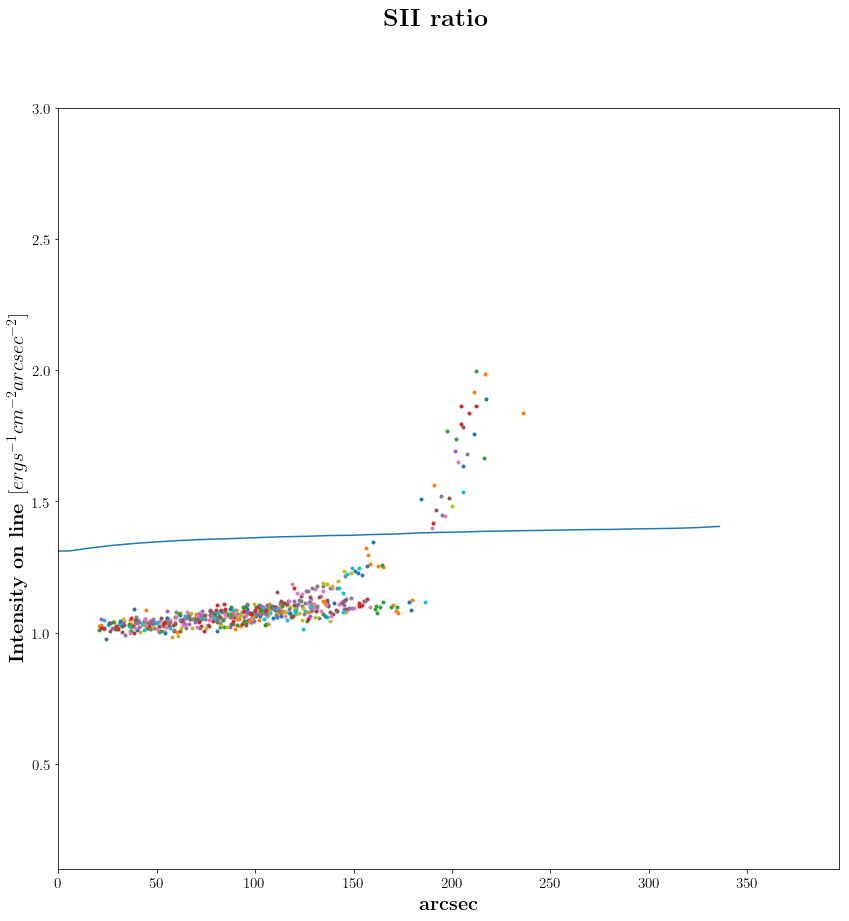

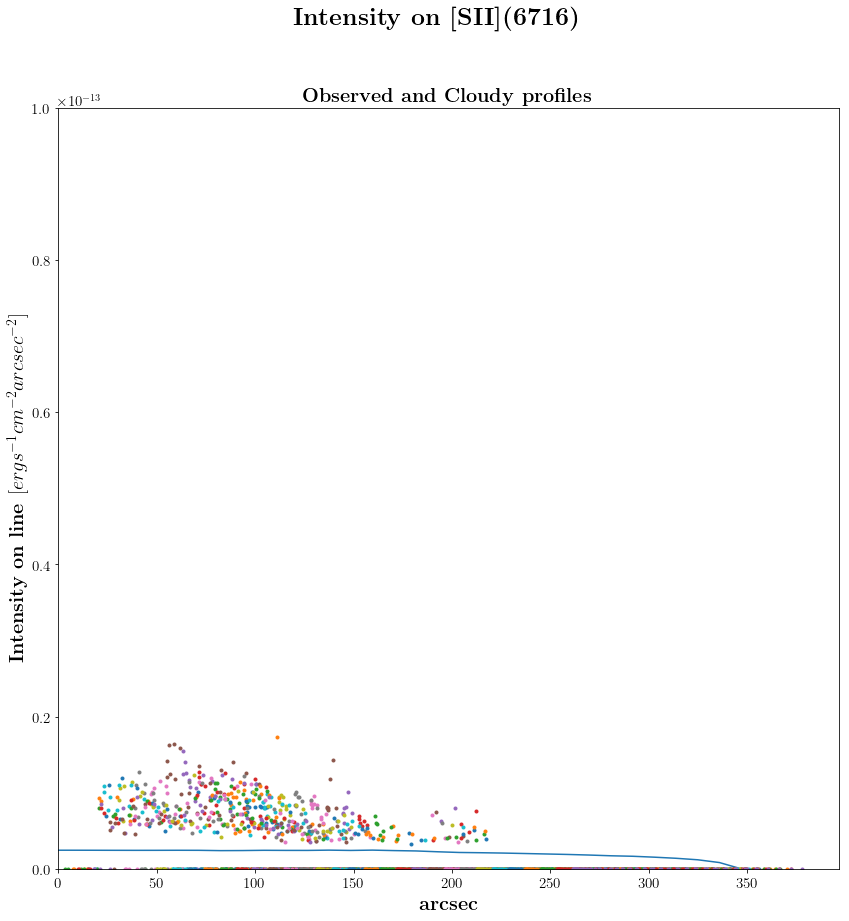

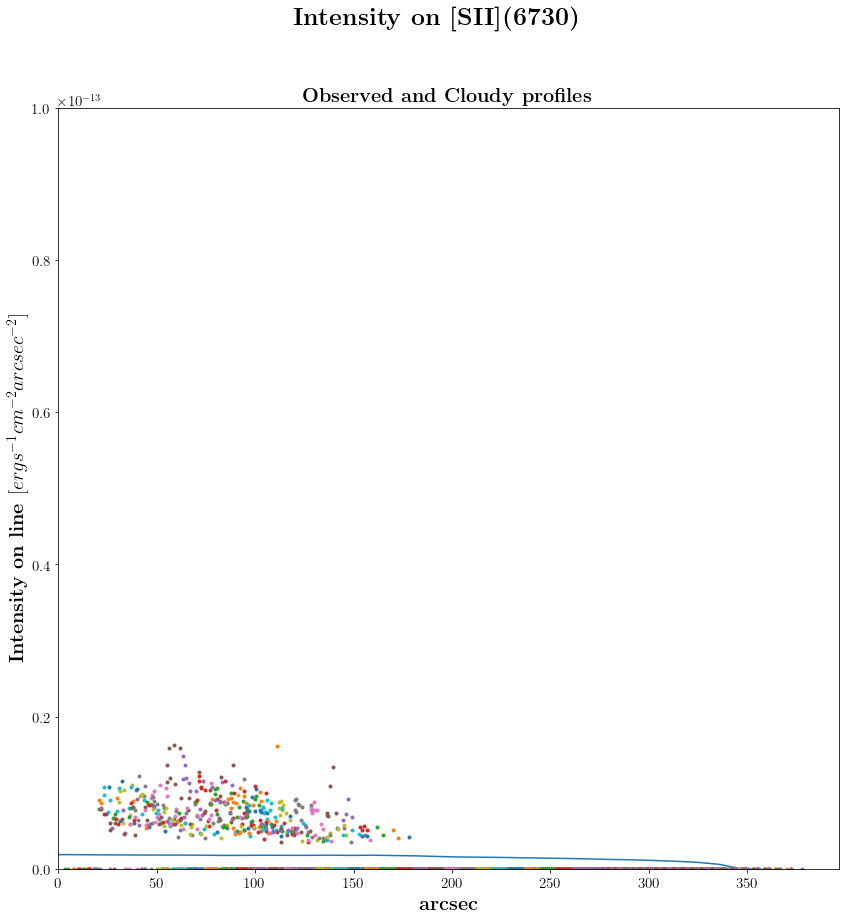

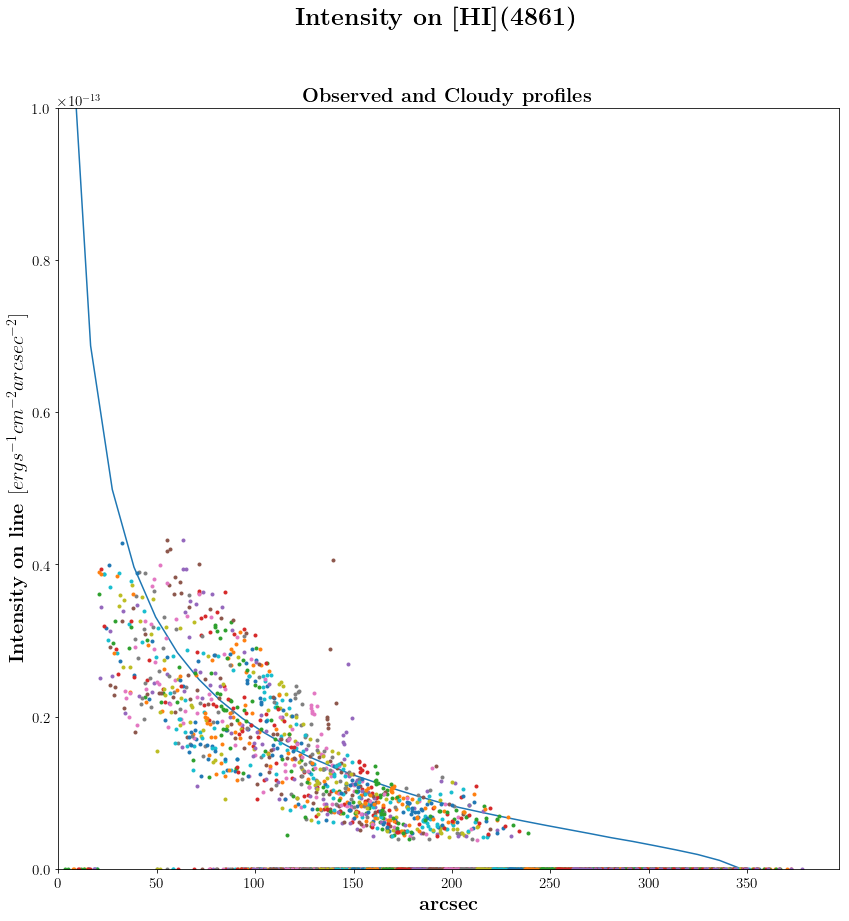

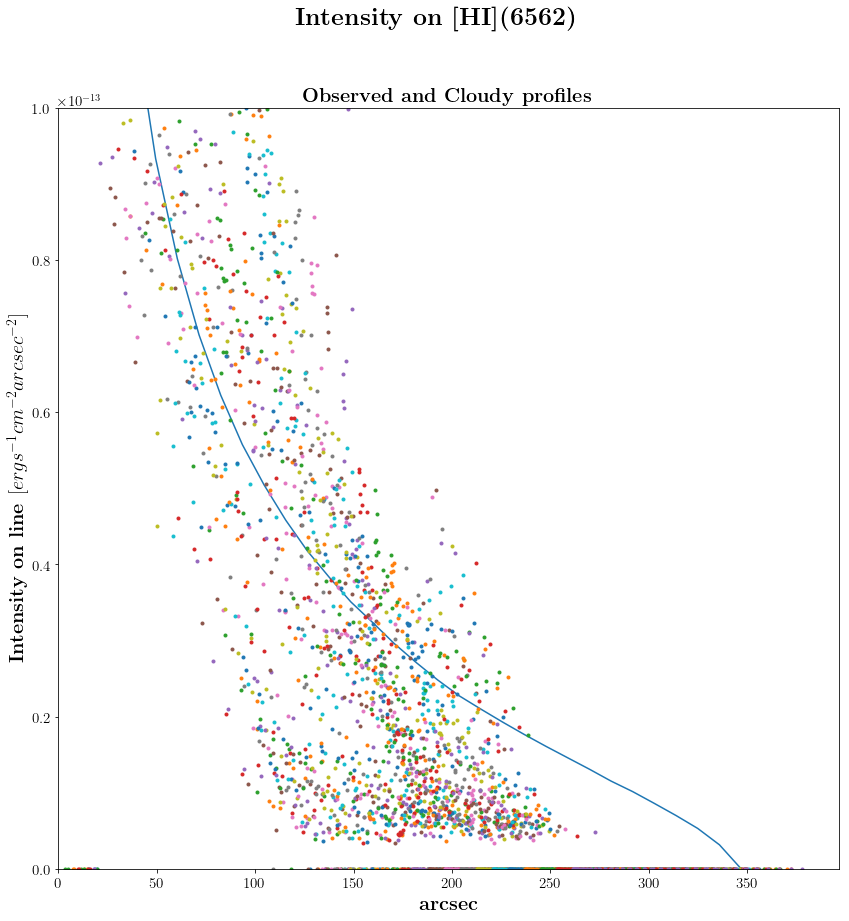

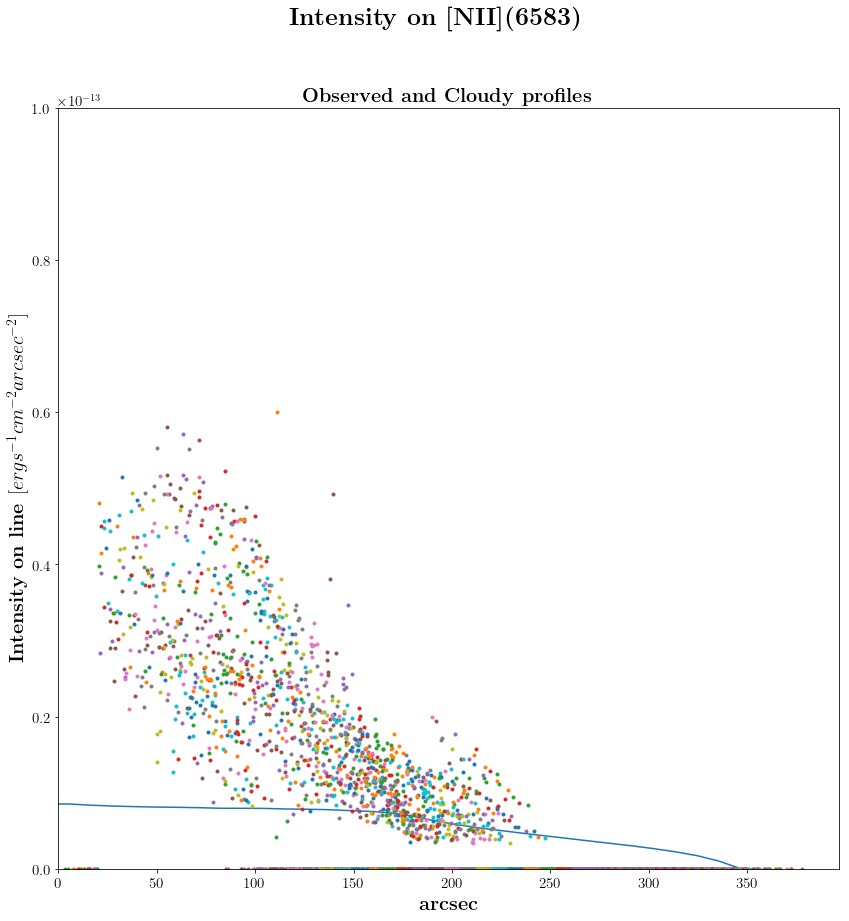

In [27]:
c_output = pc.CloudyModel('/home/mdemyanenko/CLOUDY/model_alpha_45[-0.76249999]')
cube_size = 64
M_sphere = pc.C3D(c_output, dims=cube_size, center=True, n_dim=1)

get_observe_data_ratio(M_sphere, 85.24766667, +35.84625000)
get_observe_data(M_sphere, 'S__2_671644A', 85.24766667, +35.84625000, 
                           '/home/mdemyanenko/CLOUDY/S235_mangal/S235_6717net0_ergs_dereddened.fits', 
                 '/home/mdemyanenko/CLOUDY/S235_mangal/S235_err_6717_ergs_dereddened.fits')
get_observe_data(M_sphere, 'S__2_673082A', 85.24766667, +35.84625000, 
                           '/home/mdemyanenko/CLOUDY/S235_mangal/S235_6731net0_ergs_dereddened.fits',
        '/home/mdemyanenko/CLOUDY/S235_mangal/S235_err_6731_ergs_dereddened.fits')
get_observe_data(M_sphere, 'H__1_486133A', 85.24766667, +35.84625000, 
                           '/home/mdemyanenko/CLOUDY/S235_mangal/S235_Hb_23toHa_ergs_dereddened.fits', 
       '/home/mdemyanenko/CLOUDY/S235_mangal/S235_err_Hb_23_ergs_dereddened.fits')
get_observe_data(M_sphere, 'H__1_656281A', 85.24766667, +35.84625000, 
                           '/home/mdemyanenko/CLOUDY/S235_mangal/S235_Hanet0_ergs_dereddened.fits', 
       '/home/mdemyanenko/CLOUDY/S235_mangal/S235_err_Ha_ergs_dereddened.fits')
get_observe_data(M_sphere, 'N__2_658345A', 85.24766667, +35.84625000, 
                           '/home/mdemyanenko/CLOUDY/S235_mangal/S235scan_6583_1x1_ergs_dereddened.fits', 
       '/home/mdemyanenko/CLOUDY/S235_mangal/S235_err_NII_1x1_ergs_dereddened.fits')

In [15]:
#np.savez('counts_of_alpha_and_chi', tab_alpha, chi)

In [15]:
answer = minimization_chi_from_n_a(30, 2000, 10, -1.95, 1.95, 10, 10)
print(answer)

warng CloudyInput: "None" parameter not printed
warng CloudyModel /home/mdemyanenko/CLOUDY/model_dens_alpha_30.0_-1.95: Model aborted
/home/mdemyanenko/CLOUDY/model_dens_alpha_30.0_-1.95 model read
warng CloudyInput: "None" parameter not printed
warng CloudyModel /home/mdemyanenko/CLOUDY/model_dens_alpha_30.0_-1.5166666666666666: Model aborted
/home/mdemyanenko/CLOUDY/model_dens_alpha_30.0_-1.5166666666666666 model read
warng CloudyInput: "None" parameter not printed
warng CloudyModel /home/mdemyanenko/CLOUDY/model_dens_alpha_30.0_-1.0833333333333333: Model aborted
/home/mdemyanenko/CLOUDY/model_dens_alpha_30.0_-1.0833333333333333 model read
warng CloudyInput: "None" parameter not printed
/home/mdemyanenko/CLOUDY/model_dens_alpha_30.0_-0.6499999999999999 model read
warng CloudyInput: "None" parameter not printed
/home/mdemyanenko/CLOUDY/model_dens_alpha_30.0_-0.21666666666666656 model read
warng CloudyInput: "None" parameter not printed
/home/mdemyanenko/CLOUDY/model_dens_alpha_30.0_0.

UnboundLocalError: local variable 'cm' referenced before assignment

In [ ]:
aangular_size = 720 #arcsec diametre --> то есть считаю из видимого размера 
ssize = (dist * 1000 * 206265 * 149600000 * 1000 * 100 * aangular_size) / (2 * 206265)
print(ssize)